<a href="https://colab.research.google.com/github/kjspring/stress-detection-wearable-devices/blob/main/modeling_WESAD_all_subjects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [183]:
# Load pickled data

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import pickle
import pandas as pd
import numpy as np
! pip install tsaug
import tsaug

# Main file directory for this notebook on Google Drive
os.chdir('/content/drive/MyDrive/stress-prediction')
# absolute path of data directory
PATH = os.path.join(os.path.abspath(os.getcwd()), 'data') # Path of data folder on Google Drive

import joblib
data = joblib.load(f"{PATH}/pickle/WESAD_model_data.pickle") # read pickle file
#labels = joblib.load(f"{PATH}/pickle/WESAD_labels_model.pickle") # read pickle file

Mounted at /content/drive
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 9, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    f

In [184]:
def plot_evaluation(model, file_name):
    '''
    Plotting helper function.
    Plots the Training and validation accuracy
    as well as the training and validation loss
    over the number of epochs specified
    '''
    # Import libraries
    import matplotlib.pyplot as plt
    
    acc = model.history['binary_accuracy']
    val_acc = model.history['val_binary_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(1, len(loss) + 1)
    
    fig, ax = plt.subplots(1, 2, figsize=(24 , 8))
    ax[0].plot(epochs_range, acc, 'g-', label='Training Accuracy')
    ax[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    ax[0].legend(loc='lower right')
    ax[0].title.set_text('Training and Validation Accuracy')

    ax[1].plot(epochs_range, loss, 'g-', label='Training Loss')
    ax[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss')
    ax[1].legend(loc='upper right')
    ax[1].title.set_text('Training and Validation Loss')
    fig.patch.set_facecolor('white')
    plt.savefig(f'{file_name}')
    plt.show()

In [185]:
def evaluate_model(model_filepath, history_filepath, val_data, test_data, save_plot_path):
  '''
  What does this function do?
  val_data: validation data generator
  test_data: testing data generator
  '''
  # Evaluate the model
  from tensorflow.keras.models import load_model
  import joblib

  # Load the model
  model = load_model(model_filepath)
  model_eval_val = model.evaluate(val_data,
                                  use_multiprocessing=True,
                                  batch_size=batch_size)
  
  # Load the training fit history
  fit_history = joblib.load(history_filepath) # read pickle file

  # Make Plot of Training Fit
  plot_evaluation(fit_history, save_plot_path)

  # Print validation and testing metrics
  print(f'Validation Binary Accuracy is: {model_eval_val[1]:.2f}')
  model_eval_test = model.evaluate(test_data,
                                  use_multiprocessing=True,
                                  batch_size=batch_size)
  print(f'Testing Binary Accuracy is: {model_eval_test[1]:.2f}')
  return model, fit_history

In [186]:
data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RSP_Rate    float64
 1   EDA_Phasic  float64
 2   ECG_Rate    float64
 3   Temp        float32
 4   label       int32  
dtypes: float32(1), float64(3), int32(1)
memory usage: 117.4 MB


In [18]:
data[0].describe()

,RSP_Rate,EDA_Phasic,ECG_Rate,Temp,label
count,3.847200e+06,3.847200e+06,3.847200e+06,3.847200e+06,3.847200e+06
mean,1.479597e+01,8.773488e-07,9.201702e+01,3.477422e+01,1.319141e-01
std,5.429806e+00,5.118602e-03,1.541436e+01,4.796361e-01,3.383974e-01
min,2.319673e+00,-5.590441e-02,5.391528e+01,3.365948e+01,0.000000e+00
25%,1.046479e+01,-1.277041e-03,7.972357e+01,3.438724e+01,0.000000e+00
50%,1.530387e+01,-6.004727e-05,9.191419e+01,3.461252e+01,0.000000e+00
75%,1.836961e+01,1.148620e-03,1.021086e+02,3.526480e+01,0.000000e+00
max,5.166052e+01,9.205739e-02,1.527273e+02,3.577805e+01,1.000000e+00


In [187]:
'''
engineer features that capture the patterns in your data that are relevant to 
predicting stress, you can compute statistics over different time intervals.
function compute_features that computes the mean and standard deviation of EDA 
over different time intervals using the rolling function. We then apply this 
function to each dataframe in the list using a list comprehension.
'''
# Define a function to compute features
def compute_features(df, exclude_cols=[]):
    # Compute rolling mean and standard deviation features for all columns 
    # except those in exclude_cols
    for col in df.columns:
        if col not in exclude_cols:
            windows = [int(60 * 700), int(300 * 700)]
            for window in windows:
                df[f'{col}_mean_{window // 700}s'] = df[col].rolling(window=window).mean()
                df[f'{col}_std_{window // 700}s'] = df[col].rolling(window=window).std()

    # Drop rows with missing values
    df.dropna(inplace=True)
    return df

# Apply the function to each dataframe in the list
data_frames_list = [compute_features(df, 'label') for df in data]

In [188]:
data_frames_list[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3637201 entries, 209999 to 3847199
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   RSP_Rate              float64
 1   EDA_Phasic            float64
 2   ECG_Rate              float64
 3   Temp                  float32
 4   label                 int32  
 5   RSP_Rate_mean_60s     float64
 6   RSP_Rate_std_60s      float64
 7   RSP_Rate_mean_300s    float64
 8   RSP_Rate_std_300s     float64
 9   EDA_Phasic_mean_60s   float64
 10  EDA_Phasic_std_60s    float64
 11  EDA_Phasic_mean_300s  float64
 12  EDA_Phasic_std_300s   float64
 13  ECG_Rate_mean_60s     float64
 14  ECG_Rate_std_60s      float64
 15  ECG_Rate_mean_300s    float64
 16  ECG_Rate_std_300s     float64
 17  Temp_mean_60s         float64
 18  Temp_std_60s          float64
 19  Temp_mean_300s        float64
 20  Temp_std_300s         float64
dtypes: float32(1), float64(19), int32(1)
memory usage: 582.7 MB


In [189]:
data_frames_list[0].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
RSP_Rate,3637201.0,1.465224e+01,5.447021,2.319673,10.218365,1.508318e+01,18.283006,51.660517
EDA_Phasic,3637201.0,1.119911e-07,0.005249,-0.055904,-0.001299,-6.545471e-05,0.001158,0.092057
ECG_Rate,3637201.0,9.176053e+01,15.713457,53.915276,79.223484,9.123063e+01,102.099056,152.727273
Temp,3637201.0,3.481870e+01,0.453270,34.136749,34.413239,3.464474e+01,35.298920,35.778046
label,3637201.0,1.395304e-01,0.346499,0.000000,0.000000,0.000000e+00,0.000000,1.000000
RSP_Rate_mean_60s,3637201.0,1.467262e+01,3.467658,5.527036,12.280620,1.530302e+01,17.431736,22.693054
RSP_Rate_std_60s,3637201.0,3.826718e+00,1.724227,0.875032,2.498924,3.613787e+00,4.815633,9.056521
RSP_Rate_mean_300s,3637201.0,1.477868e+01,2.611384,7.838479,13.017257,1.558836e+01,17.125320,18.760963
RSP_Rate_std_300s,3637201.0,4.612562e+00,1.114048,2.299659,3.692885,4.585956e+00,5.502934,7.192086
EDA_Phasic_mean_60s,3637201.0,-1.478569e-07,0.000233,-0.002361,-0.000035,2.393077e-07,0.000033,0.002526


In [190]:
data_frames_list[0].head()

,RSP_Rate,EDA_Phasic,ECG_Rate,Temp,label,RSP_Rate_mean_60s,RSP_Rate_std_60s,RSP_Rate_mean_300s,RSP_Rate_std_300s,EDA_Phasic_mean_60s,...,EDA_Phasic_mean_300s,EDA_Phasic_std_300s,ECG_Rate_mean_60s,ECG_Rate_std_60s,ECG_Rate_mean_300s,ECG_Rate_std_300s,Temp_mean_60s,Temp_std_60s,Temp_mean_300s,Temp_std_300s
209999,18.735205,0.000294,97.522106,34.274109,0,18.569499,1.767405,17.285465,4.436701,-0.000006,...,0.000014,0.001677,100.011176,8.531438,96.459509,7.447884,34.233057,0.038050,34.003925,0.168712
210000,18.735544,0.000264,97.519788,34.298553,0,18.569561,1.767365,17.285486,4.436698,-0.000006,...,0.000014,0.001677,100.011019,8.531423,96.459535,7.447878,34.233060,0.038051,34.003928,0.168712
210001,18.735883,0.000233,97.517502,34.281708,0,18.569623,1.767324,17.285506,4.436695,-0.000006,...,0.000014,0.001677,100.010861,8.531408,96.459561,7.447872,34.233062,0.038051,34.003930,0.168712
210002,18.736224,0.000202,97.515251,34.295502,0,18.569686,1.767284,17.285526,4.436692,-0.000006,...,0.000014,0.001677,100.010704,8.531393,96.459588,7.447866,34.233064,0.038052,34.003933,0.168712
210003,18.736564,0.000170,97.513033,34.283264,0,18.569748,1.767244,17.285546,4.436689,-0.000006,...,0.000014,0.001677,100.010546,8.531378,96.459614,7.447860,34.233068,0.038048,34.003936,0.168712


In [191]:
## Include Subject
for i, df in enumerate(data_frames_list):
    # Set subject as categorical
    df['subject'] = i
    df['subject'] = df['subject'].astype('category')

                   

In [194]:
data_frames_list[1].head()

,RSP_Rate,EDA_Phasic,ECG_Rate,Temp,label,RSP_Rate_mean_60s,RSP_Rate_std_60s,RSP_Rate_mean_300s,RSP_Rate_std_300s,EDA_Phasic_mean_60s,...,EDA_Phasic_std_300s,ECG_Rate_mean_60s,ECG_Rate_std_60s,ECG_Rate_mean_300s,ECG_Rate_std_300s,Temp_mean_60s,Temp_std_60s,Temp_mean_300s,Temp_std_300s,subject
209999,18.258615,0.002830,69.670790,33.421997,0,15.053284,2.224209,15.435419,3.839865,-0.00002,...,0.00527,71.987667,2.616515,72.062369,5.793981,33.384745,0.025339,33.176684,0.187055,1
210000,18.261560,0.002812,69.674991,33.409912,0,15.053442,2.224201,15.435436,3.839869,-0.00002,...,0.00527,71.987779,2.616317,72.062280,5.793873,33.384747,0.025339,33.176687,0.187054,1
210001,18.264506,0.002794,69.679170,33.431061,0,15.053601,2.224192,15.435454,3.839874,-0.00002,...,0.00527,71.987890,2.616118,72.062191,5.793765,33.384748,0.025340,33.176690,0.187053,1
210002,18.267451,0.002775,69.683328,33.363129,0,15.053759,2.224184,15.435472,3.839878,-0.00002,...,0.00527,71.988002,2.615920,72.062101,5.793657,33.384749,0.025339,33.176693,0.187052,1
210003,18.270397,0.002757,69.687463,33.414459,0,15.053918,2.224176,15.435489,3.839883,-0.00002,...,0.00527,71.988114,2.615721,72.062012,5.793549,33.384750,0.025339,33.176696,0.187050,1


In [195]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Concatenate the dataframes together
df = pd.concat(data_frames_list)

# Downsample the dataframe
target_hz = 1
resample_factor = int(700 / target_hz)
df = df.iloc[::resample_factor, :]

# Drop any columns that have any missing values
df = df.dropna(axis=1, how='any')

# Select 80% of subjects for training
train_subjects = df['subject'].unique()[:int(0.8 * len(df['subject'].unique()))]

# Split the data into training, testing, and validation sets by subject
train_dfs = []
test_dfs = []
val_dfs = []

for i, group in df.groupby('subject'):
    if i in train_subjects:
        train, test = train_test_split(group, test_size=0.2, random_state=42)
        train, val = train_test_split(train, test_size=0.2, random_state=42)
        
        train_dfs.append(train)
        test_dfs.append(test)
        val_dfs.append(val)
    else:
        test_dfs.append(group)

train_df = pd.concat(train_dfs)
test_df = pd.concat(test_dfs)
val_df = pd.concat(val_dfs)

# Standardize the data
scaler = StandardScaler()
cols_to_transform = [col for col in train_df.columns if col not in ['subject', 'label']]
train_df[cols_to_transform] = scaler.fit_transform(train_df[cols_to_transform])
test_df[cols_to_transform] = scaler.transform(test_df[cols_to_transform])
val_df[cols_to_transform] = scaler.transform(val_df[cols_to_transform])

# Set subject as categorical
train_df['subject'] = train_df['subject'].astype('category')
test_df['subject'] = test_df['subject'].astype('category')
val_df['subject'] = val_df['subject'].astype('category')

<Axes: >

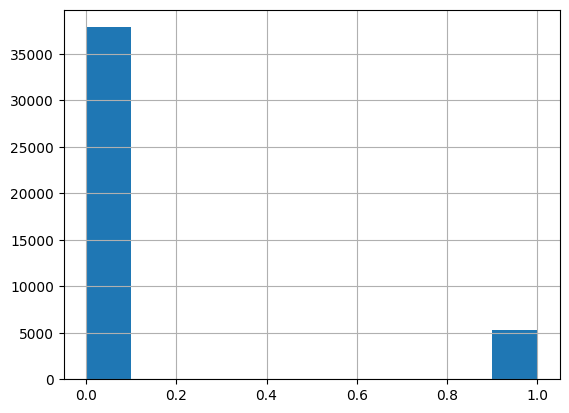

In [197]:
train_df['label'].hist()

In [198]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tsaug import TimeWarp, Drift, AddNoise

class AugmentedTimeseriesGenerator(Sequence):
    def __init__(self, x, y, batch_size, length, augmenter=None):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.length = length
        self.augmenter = augmenter

    def __len__(self):
        return len(self.x) // self.batch_size

    def __getitem__(self, index):
        x_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        y_batch = self.y[index*self.batch_size:(index+1)*self.batch_size]
        if self.augmenter and self.batch_size == 1:
            x_batch = self.augmenter.augment(x_batch)
        
        # Calculate class distribution of the batch
        unique_classes, class_counts = np.unique(y_batch, return_counts=True)
        #print(f"Batch {index} class distribution: {dict(zip(unique_classes, class_counts))}")

        return x_batch, y_batch

    def print_class_distribution(self):
        # print class distribution of the entire dataset
        unique, counts = np.unique(self.y, return_counts=True)
        print(dict(zip(unique, counts)))
        
# Define batch size and sequence length
duration = 5 # minutes
target_hz = 1
seq_length = target_hz * 60 * duration # full length of sequence
batch_size = len(train_df) // seq_length

# Calculate the offset in rows
offset_minutes = 5
offset_rows = offset_minutes * target_hz * 60 # seconds

# Drop subject ID and label columns
train_data = train_df.drop(columns=['subject', 'label'])[:batch_size*seq_length].values
val_data = val_df.drop(columns=['subject', 'label'])[:batch_size*seq_length].values
test_data = test_df.drop(columns=['subject', 'label'])[:batch_size*seq_length].values

# Shift the data based on the calculated offset rows
train_data = np.concatenate([train_data[offset_rows:], np.zeros((offset_rows, train_data.shape[1]))])
val_data = np.concatenate([val_data[offset_rows:], np.zeros((offset_rows, val_data.shape[1]))])
test_data = np.concatenate([test_data[offset_rows:], np.zeros((offset_rows, test_data.shape[1]))])
#train_data = train_data[:batch_size*seq_length]

# Reshape the data to have shape (N, T, C)
train_data = train_data.reshape(batch_size, seq_length, train_df.shape[1]-2)
val_data = train_data.reshape(batch_size, seq_length, train_df.shape[1]-2)
test_data = train_data.reshape(batch_size, seq_length, train_df.shape[1]-2)

# Define augmentation functions
augmenter = (
    TimeWarp() * 5
    + Drift(max_drift=(0.1, 0.5)) @ 0.8
    + AddNoise(scale=0.01)
)

train_gen = AugmentedTimeseriesGenerator(train_data, 
                                         train_df['label'].values,
                                         batch_size=5, 
                                         length=seq_length,
                                         augmenter=augmenter
                                         )

val_gen = AugmentedTimeseriesGenerator(val_data, 
                                       val_df['label'].values,
                                       batch_size=5, 
                                       length=seq_length)

test_gen = AugmentedTimeseriesGenerator(test_data, 
                                        test_df['label'].values,
                                        batch_size=5, 
                                        length=seq_length)

In [199]:
train_gen.print_class_distribution()

{0: 37841, 1: 5247}


In [200]:
# get the first batch of data
x_train_batch, y_train_batch = train_gen[0]
x_val_batch, y_val_batch = val_gen[0]
x_test_batch, y_test_batch = test_gen[0]

# check the shape of the input batch
print(x_train_batch.shape)
print(x_val_batch.shape)
print(x_test_batch.shape)

(5, 300, 20)
(5, 300, 20)
(5, 300, 20)


In [201]:
# Callbacks Function
def callbacks(checkpoint_file, patience=3):

  # import necessary libraries
  from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

  # Callback and Early Stopping
  callbacks = [EarlyStopping(monitor='val_loss', 
                             verbose=1, 
                             patience=patience,
                             restore_best_weights=True,
                             mode='min'
                             ),
              ModelCheckpoint(checkpoint_file, 
                              save_best_only=True,
                              verbose=0
                              ),
              TensorBoard(log_dir='./logs', histogram_freq=1, 
                          embeddings_freq=1, 
                          update_freq='epoch')
  ]
  return callbacks

In [202]:
train_gen[0][0][0][0]

array([-0.84037767, -0.19385218,  1.22357787,  1.43604094, -0.54639071,
        0.40548991, -0.239184  ,  1.67870133,  0.07983513, -0.16395225,
        0.15155908, -0.22658864,  1.70052813,  1.08514521,  2.37266602,
        1.54416801,  1.43072108,  0.00782109,  1.05163386,  0.34869677])

Class 0 (Non-stress): 84.29%
Class 1 (Stress): 15.71%


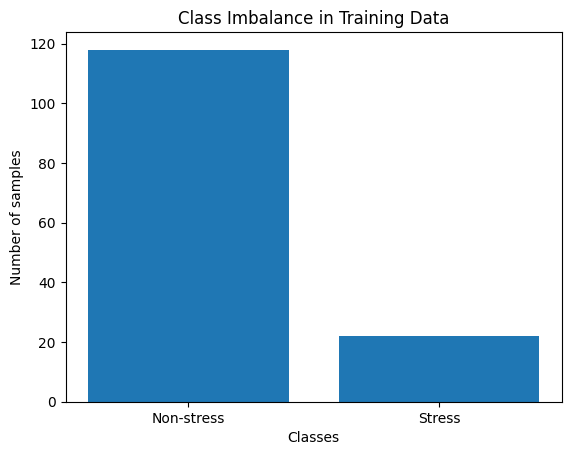

In [203]:
# Class imbalance

# Class weight correction
from sklearn.utils import class_weight

y_train = np.concatenate([train_gen[i][1] for i in range(len(train_gen))])

import matplotlib.pyplot as plt
import numpy as np

# Calculate class counts
unique_classes, class_counts = np.unique(y_train, return_counts=True)
class_percentages = (class_counts / class_counts.sum()) * 100

# Calculate class weights
class_weights = class_weight.compute_sample_weight(class_weight='balanced', 
                                                   y=y_train)

# Define class weight dictionary
zero_count = class_counts[0]
one_count = class_counts[1]
class_weights_dict = {0: 1 / zero_count, 1: 1 / one_count}

#class_weights_dict = {class_label: class_weight
#                      for class_label, class_weight in zip(unique_classes,  len(y_train) / (2*class_counts))}

# Print class percentages
for class_id, percentage in zip(unique_classes, class_percentages):
    print(f"Class {class_id} ({'Non-stress' if class_id == 0 else 'Stress'}): {percentage:.2f}%")

# Create a bar plot for class counts
plt.bar(unique_classes, class_counts, tick_label=['Non-stress', 'Stress'])
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Class Imbalance in Training Data')
plt.show()

In [204]:
def confusion_matrix_plot(model, data, save_file=None):
    # Confusion Matrix
    y_pred_probs = model.predict(data)
    y_pred = (y_pred_probs > 0.5).astype(int)

    y_true = []
    for _, batch_labels in data:
        y_true.extend(batch_labels)
    y_true = np.array(y_true)

    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)

    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    if save_file:
        plt.savefig(f'{save_file}')
    plt.show()


In [205]:
# Classification Report
from sklearn.metrics import classification_report

def classification_report_output(model, data, save_file=None):
    y_pred_probs = model.predict(data)
    y_pred = (y_pred_probs > 0.5).astype(int)

    y_true = []
    for _, batch_labels in data:
        y_true.extend(batch_labels)
    y_true = np.array(y_true)

    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    if save_file:
        report_df.to_csv(save_file, index=True)

    print(report_df)

In [206]:
print(train_gen[0][0].shape)
# get the first batch of data
x_batch, y_batch = train_gen[0]

# check the shape of the input batch
print(x_batch.shape)

(5, 300, 20)
(5, 300, 20)


In [207]:
'''
Model_0: Densely Connected Network
This neural network starts by flattening the data dn then runs it through two 
Dense layers.

This is a simple and cheap model to test the data generator and the metrics
being used to evaluate.
'''

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, Flatten

# Build Model 0
inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))
x = Flatten()(inputs)
x = Dense(16, activation='relu')(x)
outputs = Dense(1)(x)
model_0 = keras.Model(inputs, outputs, name='model_0')

# Compile Model 0
model_0.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['binary_accuracy'])


model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 300, 20)]         0         
                                                                 
 flatten_3 (Flatten)         (None, 6000)              0         
                                                                 
 dense_13 (Dense)            (None, 16)                96016     
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 96,033
Trainable params: 96,033
Non-trainable params: 0
_________________________________________________________________


In [208]:
# Parameters for fitting and saving model training data
epochs = 200
model_0_filepath = 'models/model_dense.keras'
history_0_filepath = 'models/trainHistoryDict/model_0_dense_history.pkl'

In [209]:
# Fit the model to the training data
history_0 = model_0.fit(train_gen, 
                        validation_data=val_gen,
                        shuffle=True, 
                        epochs=epochs,
                        class_weight=class_weights_dict,
                        callbacks=callbacks(model_0_filepath,
                                            patience=5),
                        # remove the last batch if not even
                        #steps_per_epoch=len(train_gen)-1
                        )

# Pickle the Traning Fit History
with open(history_0_filepath, 'wb') as file_pi:
    pickle.dump(history_0, file_pi)

Epoch 1/200
28/28 [==============================] - 2s 39ms/step - loss: 0.1209 - binary_accuracy: 0.3143 - val_loss: 8.3379 - val_binary_accuracy: 0.4286
Epoch 2/200
28/28 [==============================] - 0s 11ms/step - loss: 0.1109 - binary_accuracy: 0.4071 - val_loss: 8.7688 - val_binary_accuracy: 0.4071
Epoch 3/200
28/28 [==============================] - 0s 10ms/step - loss: 0.1222 - binary_accuracy: 0.4429 - val_loss: 6.2327 - val_binary_accuracy: 0.5786
Epoch 4/200
28/28 [==============================] - 0s 10ms/step - loss: 0.0729 - binary_accuracy: 0.6571 - val_loss: 6.8735 - val_binary_accuracy: 0.5500
Epoch 5/200
28/28 [==============================] - 0s 10ms/step - loss: 0.0738 - binary_accuracy: 0.6500 - val_loss: 6.5520 - val_binary_accuracy: 0.5643
Epoch 6/200
28/28 [==============================] - 0s 11ms/step - loss: 0.0762 - binary_accuracy: 0.6571 - val_loss: 6.0118 - val_binary_accuracy: 0.6000
Epoch 7/200
28/28 [==============================] - 0s 12ms/ste

28/28 [==============================] - 0s 8ms/step - loss: 6.0021 - binary_accuracy: 0.6071


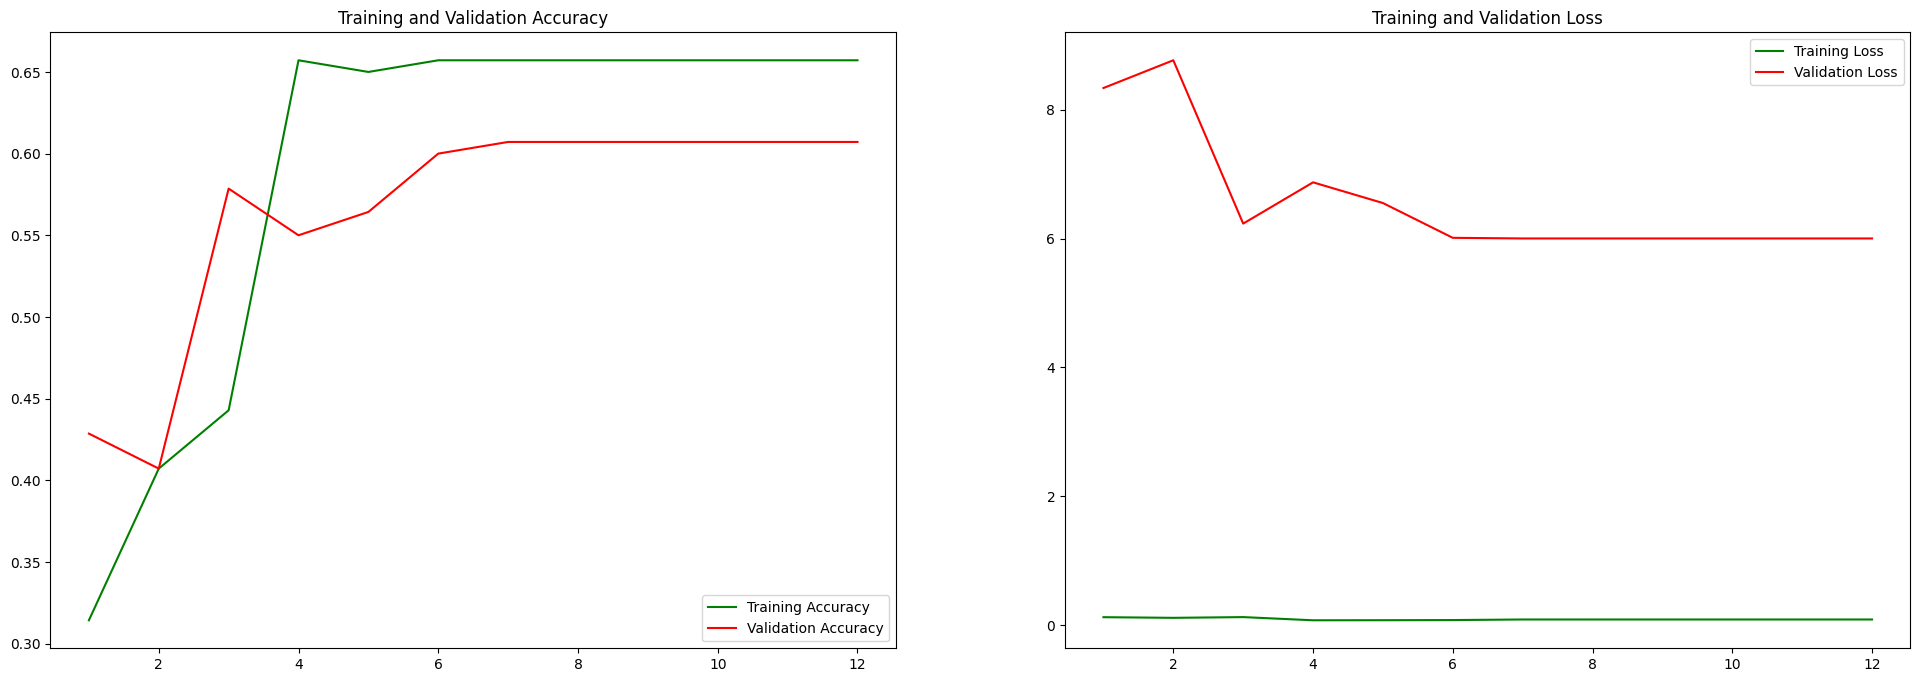

Validation Binary Accuracy is: 0.61
28/28 [==============================] - 0s 8ms/step - loss: 6.6631 - binary_accuracy: 0.5643
Testing Binary Accuracy is: 0.56


In [210]:
# Load and Evaluate Model
model_0, history_0 = evaluate_model(model_0_filepath, 
                         history_0_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_0_evaluation.pdf')

28/28 [==============================] - 0s 1ms/step


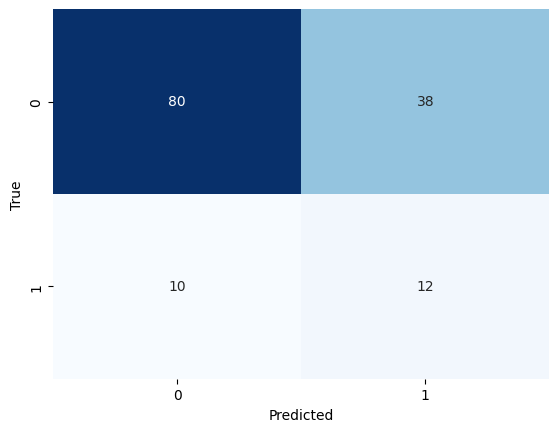

28/28 [==============================] - 0s 1ms/step
              precision    recall  f1-score     support
0              0.888889  0.677966  0.769231  118.000000
1              0.240000  0.545455  0.333333   22.000000
accuracy       0.657143  0.657143  0.657143    0.657143
macro avg      0.564444  0.611710  0.551282  140.000000
weighted avg   0.786921  0.657143  0.700733  140.000000
28/28 [==============================] - 0s 1ms/step


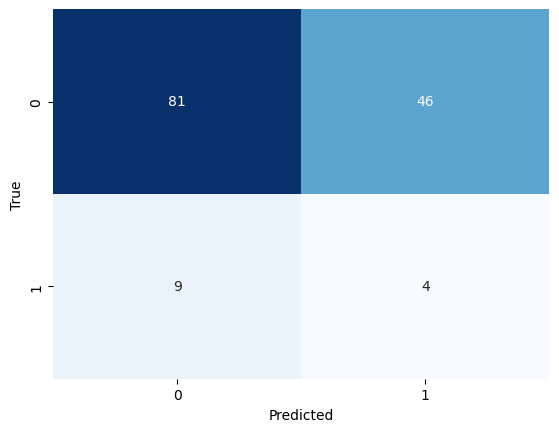

28/28 [==============================] - 0s 2ms/step
              precision    recall  f1-score     support
0              0.900000  0.637795  0.746544  127.000000
1              0.080000  0.307692  0.126984   13.000000
accuracy       0.607143  0.607143  0.607143    0.607143
macro avg      0.490000  0.472744  0.436764  140.000000
weighted avg   0.823857  0.607143  0.689013  140.000000
28/28 [==============================] - 0s 1ms/step


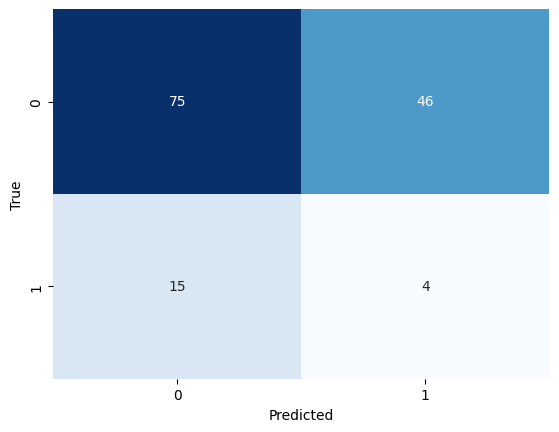

28/28 [==============================] - 0s 2ms/step
              precision    recall  f1-score     support
0              0.833333  0.619835  0.710900  121.000000
1              0.080000  0.210526  0.115942   19.000000
accuracy       0.564286  0.564286  0.564286    0.564286
macro avg      0.456667  0.415181  0.413421  140.000000
weighted avg   0.731095  0.564286  0.630156  140.000000


In [211]:
confusion_matrix_plot(model_0, train_gen, save_file='models/evaluate/model_0_train_confusion_matrix.pdf')
classification_report_output(model_0, train_gen, save_file=None)
confusion_matrix_plot(model_0, val_gen, save_file='models/evaluate/model_0_val_confusion_matrix.pdf')
classification_report_output(model_0, val_gen, save_file=None)
confusion_matrix_plot(model_0, test_gen, save_file='models/evaluate/model_0_test_confusion_matrix.pdf')
classification_report_output(model_0, test_gen, save_file=None)

In [237]:
# Hyperparameter Tuning
def nn_lstm_hyperparameter_tuning(build_model_fn, 
                                  lstm_units_list, 
                                  weight_penalty_list,
                                  learning_rates_list, 
                                  callback_filepath):
    import numpy as np
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    # Placeholder for the best model and its corresponding hyperparameters
    best_model = None
    best_lstm_units = None
    best_learning_rate = None
    best_penalty = None
    best_val_metric = -np.inf  # Set initial value to negative infinity

    # Loop through all combinations of LSTM units and learning rates
    for lstm_units in lstm_units_list:
        for learning_rate in learning_rates_list:
          for weight_penalty in weight_penalty_list:
            # Display the variables
            print(f'lstm_units: {lstm_units}, learning_rate: {learning_rate}, weight_penalty: {weight_penalty}')
            
            # Build model
            model = build_model_fn(lstm_units, learning_rate)

            # Set weight penalty
            class_weights_dict[1] = class_weights_dict[1] * weight_penalty         

            # Train the model on the training set
            history = model.fit(train_gen, 
                                shuffle=False,
                                validation_data=val_gen, 
                                epochs=epochs, 
                                class_weight=class_weights_dict,
                                callbacks=callbacks(callback_filepath,
                                                    patience=5))

            # Evaluate the model on the validation set
            y_val_true = np.concatenate([y for x, y in val_gen], axis=0)
            y_val_pred_probs = model.predict(val_gen)
            y_val_pred = (y_val_pred_probs > 0.5).astype(int)

            # Calculate the performance metric(s) of interest (e.g., F1-score)
            val_f1_score = f1_score(y_val_true, y_val_pred)

            # Update the best model and hyperparameters if the current model is better
            if val_f1_score > best_val_metric:
                best_history = history
                best_val_metric = val_f1_score
                best_model = model
                best_lstm_units = lstm_units
                best_learning_rate = learning_rate
                best_penalty = weight_penalty

    # Print the best LSTM units and learning rate
    print(f"Best LSTM units: {best_lstm_units}")
    print(f"Best learning rate: {best_learning_rate}")
    print(f"Best weight_penalty: {best_penalty}")

    return history, best_model, best_lstm_units, best_learning_rate, best_penalty


In [238]:
def build_lstm_model(lstm_units, learning_rate):
    from tensorflow import keras
    from tensorflow.keras.optimizers import Adam
    from keras.layers import Dense, LSTM

    inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))
    x = LSTM(units=lstm_units, 
          activation='tanh', 
          dropout=0.5)(inputs)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate), 
                  metrics=['binary_accuracy'])

    return model

In [239]:
# Parameters for fitting and saving model training data
epochs = 200
model_1_filepath = 'models/model_1_lstm.keras'
history_1_filepath = 'models/trainHistoryDict/model_1_lstm_history.pkl'

In [240]:

lstm_units_list = [32]
learning_rates_list = [0.001]
class_weight_penalty= [1]
# Fit the model to the training data

history_1, model_1, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                                      build_lstm_model,
                                                                      lstm_units_list,
                                                                      class_weight_penalty,
                                                                      learning_rates_list,
                                                                      model_1_filepath)

# Pickle the Traning Fit History
with open(history_1_filepath, 'wb') as file_pi:
    pickle.dump(history_1, file_pi)

lstm_units: 32, learning_rate: 0.001, weight_penalty: 1
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 300, 20)]         0         
                                                                 
 lstm_15 (LSTM)              (None, 32)                6784      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,817
Trainable params: 6,817
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
28/28 [==============================] - 4s 61ms/step - loss: 0.0101 - binary_accuracy: 0.5286 - val_loss: 0.6747 - val_binary_accuracy: 0.5714
Epoch 2/200
28/28 [==============================] - 1s 20ms/step - loss: 0.0094 - binary_accuracy: 0.6500 -

28/28 [==============================] - 1s 11ms/step - loss: 0.6747 - binary_accuracy: 0.5714


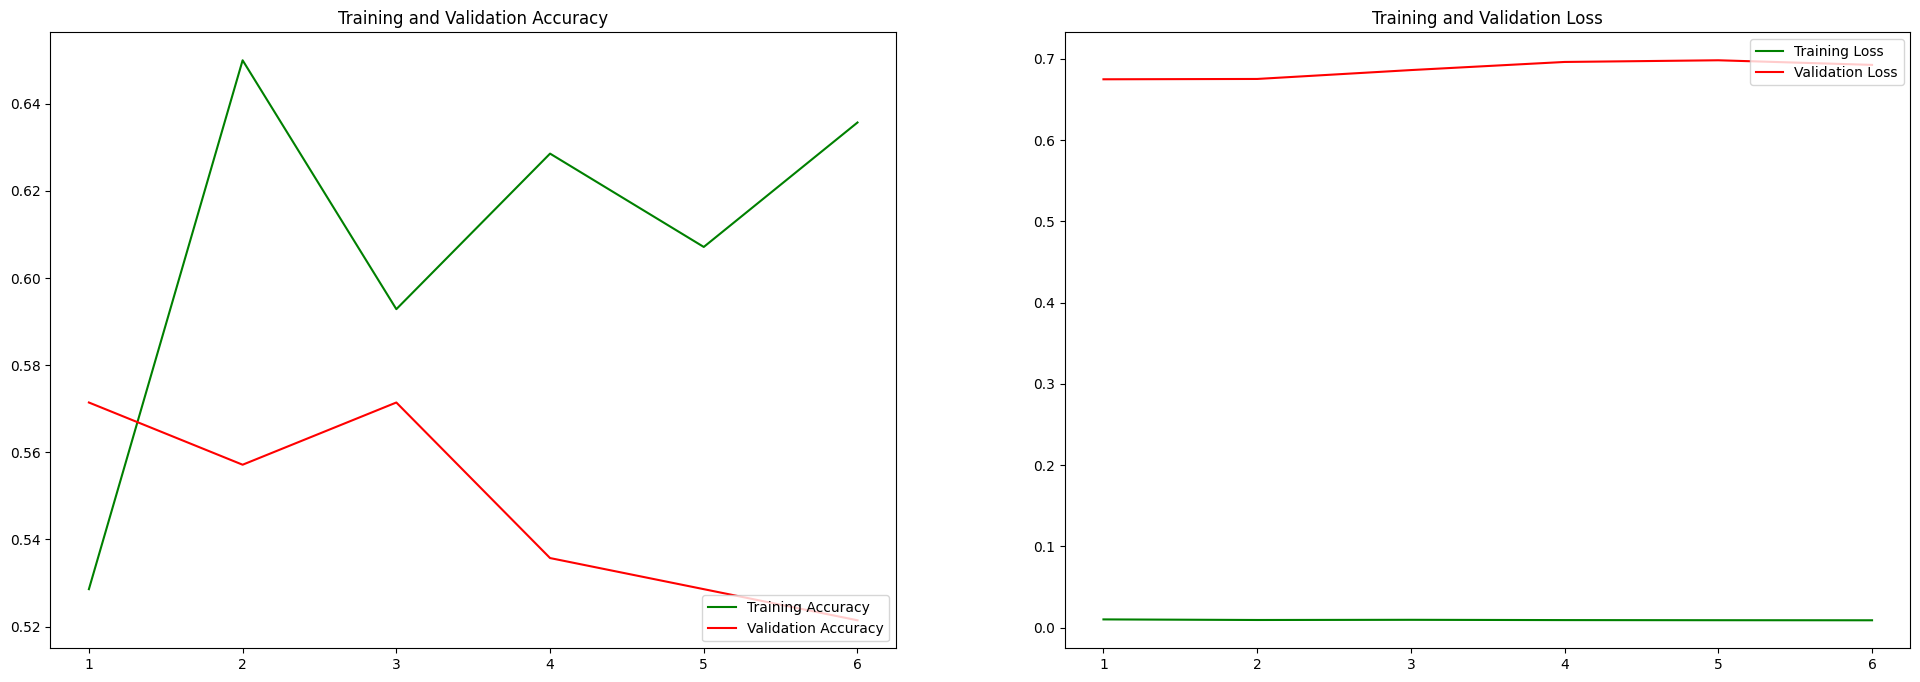

Validation Binary Accuracy is: 0.57
28/28 [==============================] - 1s 11ms/step - loss: 0.7060 - binary_accuracy: 0.4857
Testing Binary Accuracy is: 0.49


In [241]:
# Load and Evaluate Model
model_1, history_1 = evaluate_model(model_1_filepath, 
                         history_1_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_1_evaluation.pdf')

28/28 [==============================] - 1s 5ms/step


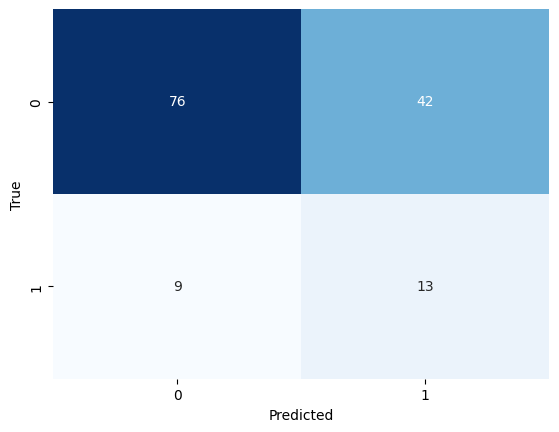

28/28 [==============================] - 0s 5ms/step
              precision    recall  f1-score     support
0              0.894118  0.644068  0.748768  118.000000
1              0.236364  0.590909  0.337662   22.000000
accuracy       0.635714  0.635714  0.635714    0.635714
macro avg      0.565241  0.617488  0.543215  140.000000
weighted avg   0.790756  0.635714  0.684166  140.000000
28/28 [==============================] - 0s 4ms/step


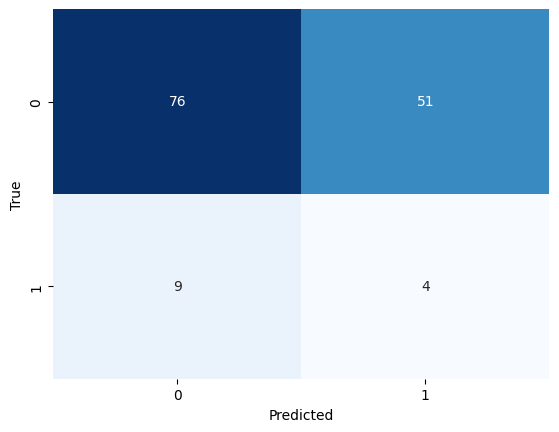

28/28 [==============================] - 0s 4ms/step
              precision    recall  f1-score     support
0              0.894118  0.598425  0.716981  127.000000
1              0.072727  0.307692  0.117647   13.000000
accuracy       0.571429  0.571429  0.571429    0.571429
macro avg      0.483422  0.453059  0.417314  140.000000
weighted avg   0.817846  0.571429  0.661329  140.000000
28/28 [==============================] - 0s 4ms/step


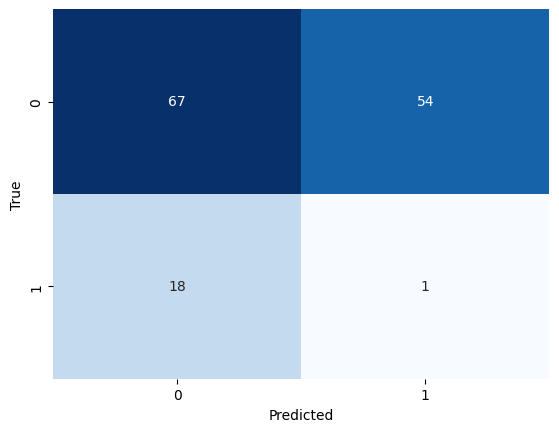

28/28 [==============================] - 0s 5ms/step
              precision    recall  f1-score     support
0              0.788235  0.553719  0.650485  121.000000
1              0.018182  0.052632  0.027027   19.000000
accuracy       0.485714  0.485714  0.485714    0.485714
macro avg      0.403209  0.303175  0.338756  140.000000
weighted avg   0.683728  0.485714  0.565873  140.000000


In [242]:
confusion_matrix_plot(model_1, train_gen, save_file='models/evaluate/model_1_train_confusion_matrix.pdf')
classification_report_output(model_1, train_gen, save_file=None)
confusion_matrix_plot(model_1, val_gen, save_file='models/evaluate/model_1_val_confusion_matrix.pdf')
classification_report_output(model_1, val_gen, save_file=None)
confusion_matrix_plot(model_1, test_gen, save_file='models/evaluate/model_1_test_confusion_matrix.pdf')
classification_report_output(model_1, test_gen, save_file=None)

In [243]:
# Model 2
def build_lstm_2_model(lstm_units, learning_rate):
    import keras
    from keras.layers import LSTM, Dense
    from keras.models import Sequential
    from tensorflow.keras.optimizers import Adam

    # Build the model
    inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

    # LSTM layer
    x = LSTM(lstm_units, 
            activation='tanh', 
            input_shape=(seq_length, train_gen[0][0].shape[2]),
             return_sequences = True,
            dropout=0.5)(inputs) # Dropout
    # Second LSTM Layer
    x = LSTM(lstm_units//2, 
            activation='tanh', 
            dropout=0.5)(x) # Dropout
    outputs = Dense(1, 'sigmoid')(x)
    model = keras.Model(inputs, outputs)

    # Compile
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate), 
                  metrics=['binary_accuracy'])

    model.summary()

    return model

In [244]:
model_2_filepath = 'models/model_2_multiLSTM.keras'
history_2_filepath = 'models/trainHistoryDict/model_2_dense_history.pkl'
lstm_units_list = [best_lstm_units]
learning_rates_list = [best_learning_rate]
class_weight_penalty= [best_penalty]

In [245]:
print(lstm_units_list)
print(learning_rates_list)
print(class_weight_penalty)

[32]
[0.001]
[1]


In [246]:
# Fit the model to the training data
history_2, model_2, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_2_model,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_2_filepath)
# Pickle the Traning Fit History
with open(history_2_filepath, 'wb') as file_pi:
    pickle.dump(history_2, file_pi)

lstm_units: 32, learning_rate: 0.001, weight_penalty: 1
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 300, 20)]         0         
                                                                 
 lstm_16 (LSTM)              (None, 300, 32)           6784      
                                                                 
 lstm_17 (LSTM)              (None, 16)                3136      
                                                                 
 dense_21 (Dense)            (None, 1)                 17        
                                                                 
Total params: 9,937
Trainable params: 9,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
28/28 [==============================] - 6s 79ms/step - loss: 0.0098 - binary_accuracy: 0.5643 - val_loss: 0.7010 - val_

28/28 [==============================] - 1s 13ms/step - loss: 0.7010 - binary_accuracy: 0.4929


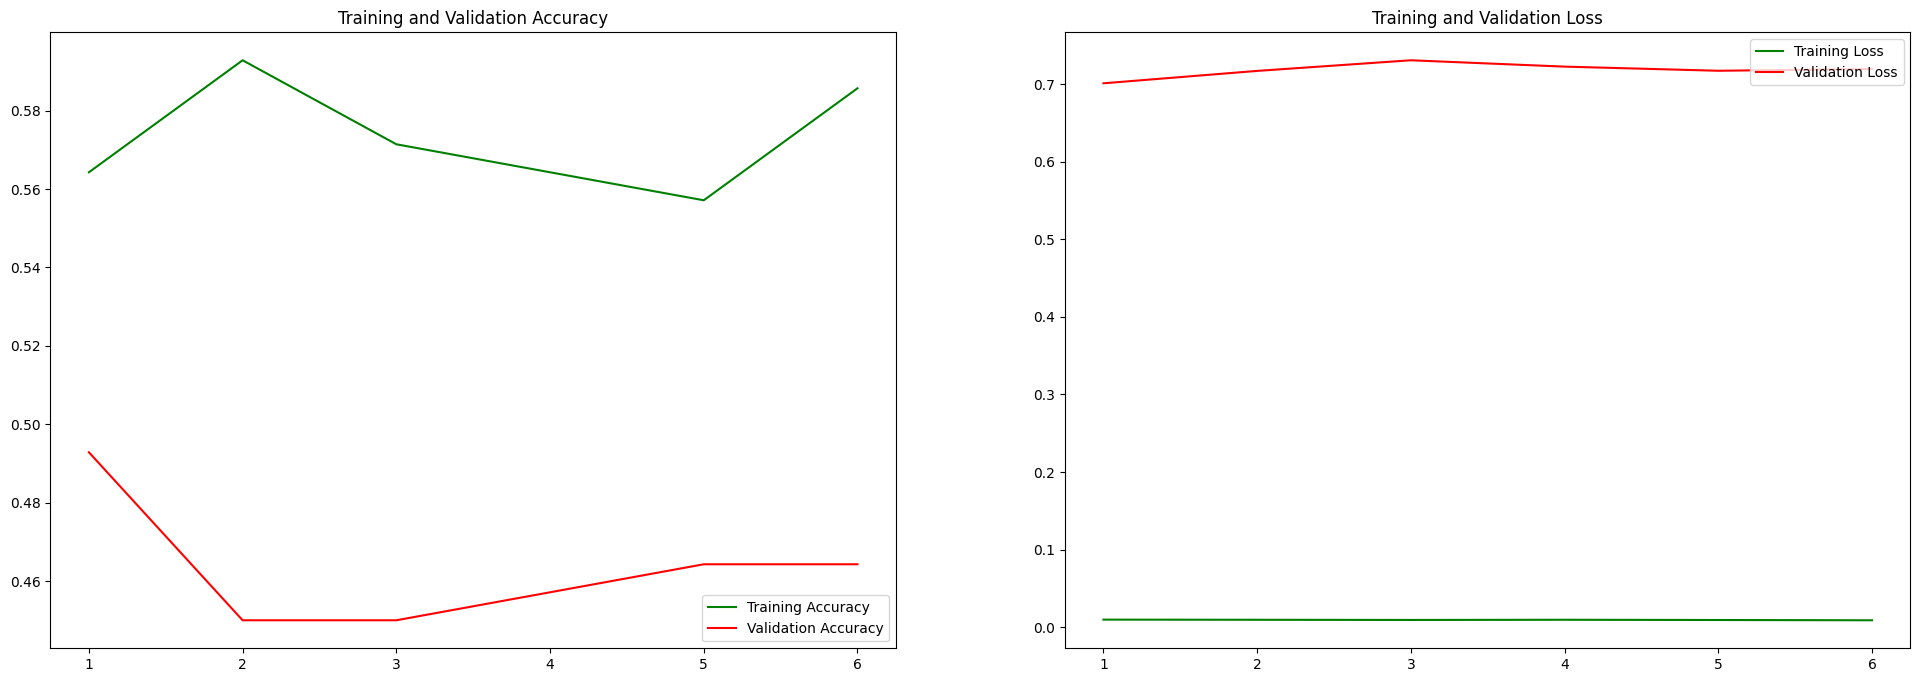

Validation Binary Accuracy is: 0.49
28/28 [==============================] - 1s 12ms/step - loss: 0.7272 - binary_accuracy: 0.4500
Testing Binary Accuracy is: 0.45


In [247]:
# Load and Evaluate Model
model_2, history_2 = evaluate_model(model_2_filepath, 
                         history_2_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_2_evaluation.pdf')

28/28 [==============================] - 1s 9ms/step


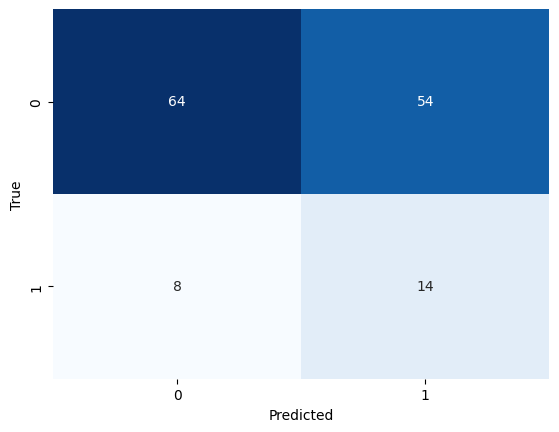

28/28 [==============================] - 0s 8ms/step
              precision    recall  f1-score     support
0              0.888889  0.542373  0.673684  118.000000
1              0.205882  0.636364  0.311111   22.000000
accuracy       0.557143  0.557143  0.557143    0.557143
macro avg      0.547386  0.589368  0.492398  140.000000
weighted avg   0.781559  0.557143  0.616708  140.000000
28/28 [==============================] - 0s 7ms/step


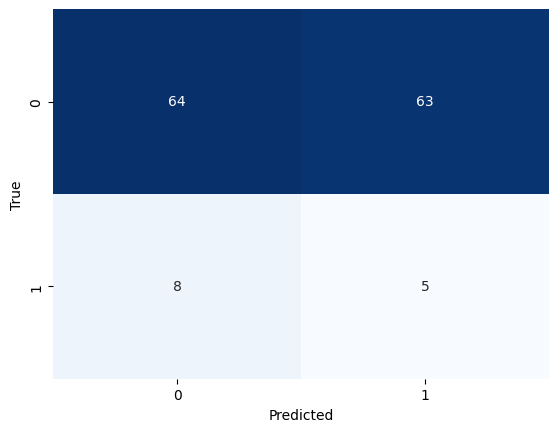

28/28 [==============================] - 0s 7ms/step
              precision    recall  f1-score     support
0              0.888889  0.503937  0.643216  127.000000
1              0.073529  0.384615  0.123457   13.000000
accuracy       0.492857  0.492857  0.492857    0.492857
macro avg      0.481209  0.444276  0.383336  140.000000
weighted avg   0.813177  0.492857  0.594953  140.000000
28/28 [==============================] - 0s 7ms/step


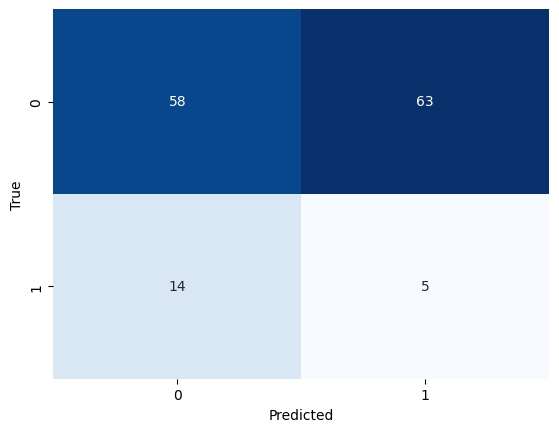

28/28 [==============================] - 0s 7ms/step
              precision    recall  f1-score  support
0              0.805556  0.479339  0.601036   121.00
1              0.073529  0.263158  0.114943    19.00
accuracy       0.450000  0.450000  0.450000     0.45
macro avg      0.439542  0.371248  0.357989   140.00
weighted avg   0.706209  0.450000  0.535066   140.00


In [248]:
confusion_matrix_plot(model_2, train_gen, save_file='models/evaluate/model_2_train_confusion_matrix.pdf')
classification_report_output(model_2, train_gen, save_file=None)
confusion_matrix_plot(model_2, val_gen, save_file='models/evaluate/model_2_val_confusion_matrix.pdf')
classification_report_output(model_2, val_gen, save_file=None)
confusion_matrix_plot(model_2, test_gen, save_file='models/evaluate/model_2_test_confusion_matrix.pdf')
classification_report_output(model_2, test_gen, save_file=None)

In [249]:
# Model 3
def build_lstm_2_norm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Dropout
  from tensorflow.keras.optimizers import Adam
  from keras.layers.normalization.batch_normalization_v1 import BatchNormalization

  # Build the model
  inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

  # LSTM layer
  x = LSTM(lstm_units, 
          activation='tanh', 
          input_shape=(seq_length, train_gen[0][0].shape[2]),
          return_sequences=True,
          dropout=0.5)(inputs) # Dropout
  # Second LSTM Layer
  x = BatchNormalization()(x)
  x = LSTM(lstm_units//2, 
          activation='tanh', 
          return_sequences=False,  # Set return_sequences=False
          dropout=0.5)(x) # Dropout
  x = BatchNormalization()(x)
  # Dense layer for binary prediction
  outputs = Dense(1, activation='sigmoid')(x)

  model = keras.Model(inputs, outputs)

  # Compile
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate=learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model

In [250]:
model_3_filepath = 'models/model_3_multiLSTM.keras'
history_3_filepath = 'models/trainHistoryDict/model_3_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.0001, 0.001, 0.01, 0.1]
#class_weight_penalty = [1, 2, 10, 100, 1000]

In [251]:
# Fit the model and tune hyperparameters
history_3, model_3, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_2_norm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_3_filepath)
# Pickle the Training Fit History
with open(history_3_filepath, 'wb') as file_pi:
    pickle.dump(history_3, file_pi)

lstm_units: 32, learning_rate: 0.001, weight_penalty: 1
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 300, 20)]         0         
                                                                 
 lstm_18 (LSTM)              (None, 300, 32)           6784      
                                                                 
 batch_normalization_4 (Batc  (None, 300, 32)          128       
 hNormalization)                                                 
                                                                 
 lstm_19 (LSTM)              (None, 16)                3136      
                                                                 
 batch_normalization_5 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 d

28/28 [==============================] - 1s 15ms/step - loss: 0.7148 - binary_accuracy: 0.3857


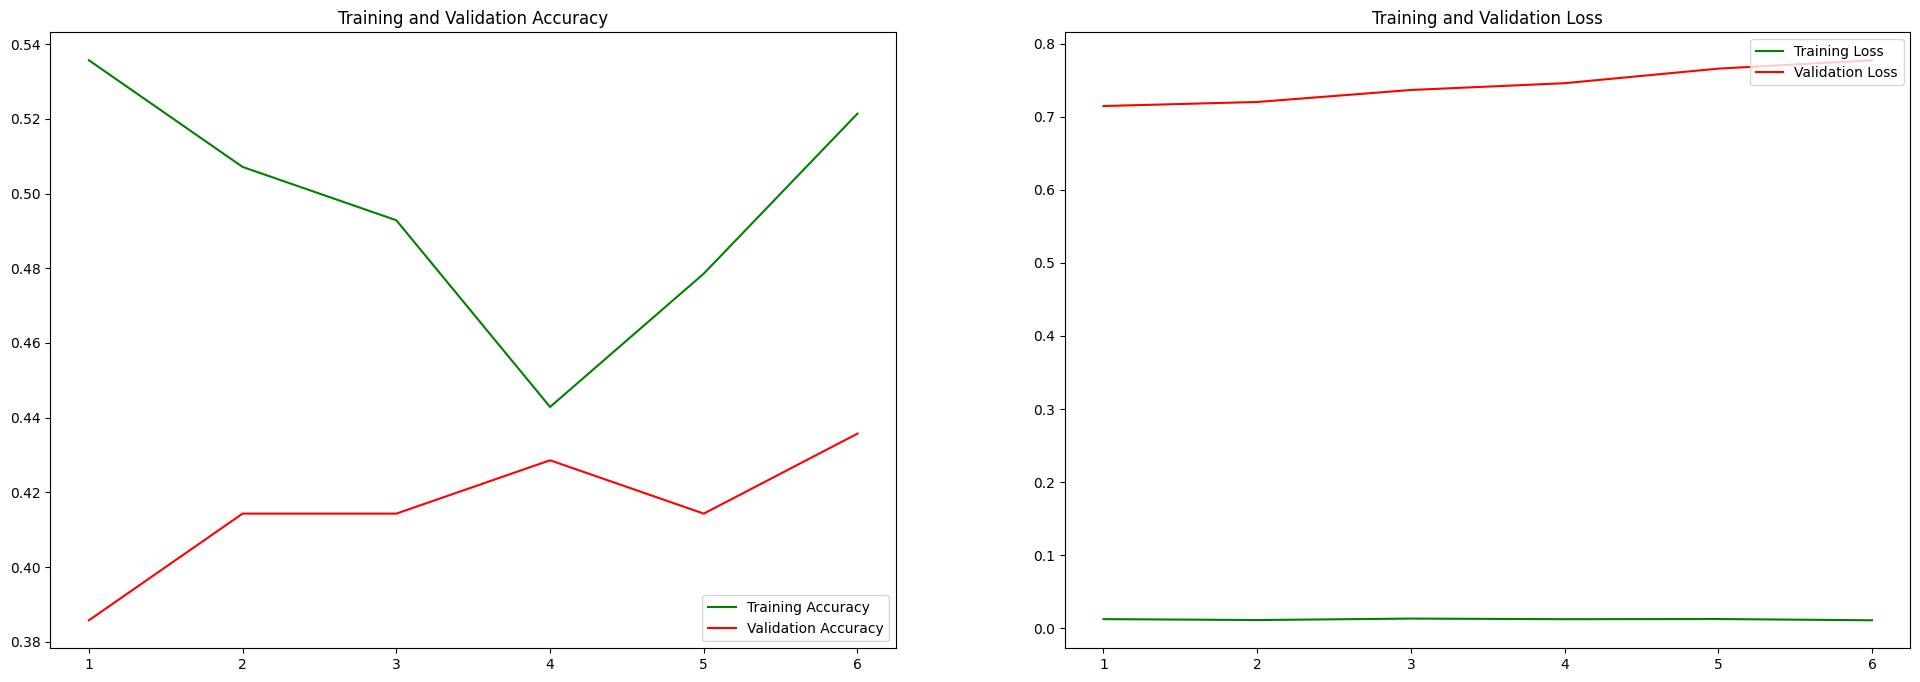

Validation Binary Accuracy is: 0.39
28/28 [==============================] - 1s 14ms/step - loss: 0.7001 - binary_accuracy: 0.4571
Testing Binary Accuracy is: 0.46


In [252]:
# Load and Evaluate Model
model_3, history_3 = evaluate_model(model_3_filepath, 
                         history_3_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_3_evaluation.pdf')

28/28 [==============================] - 1s 7ms/step


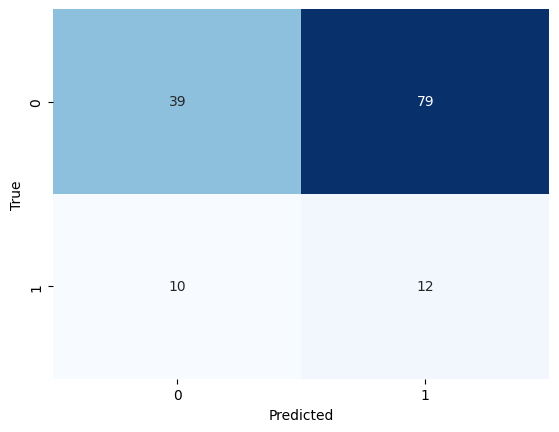

28/28 [==============================] - 0s 7ms/step
              precision    recall  f1-score     support
0              0.795918  0.330508  0.467066  118.000000
1              0.131868  0.545455  0.212389   22.000000
accuracy       0.364286  0.364286  0.364286    0.364286
macro avg      0.463893  0.437982  0.339728  140.000000
weighted avg   0.691568  0.364286  0.427045  140.000000
28/28 [==============================] - 0s 7ms/step


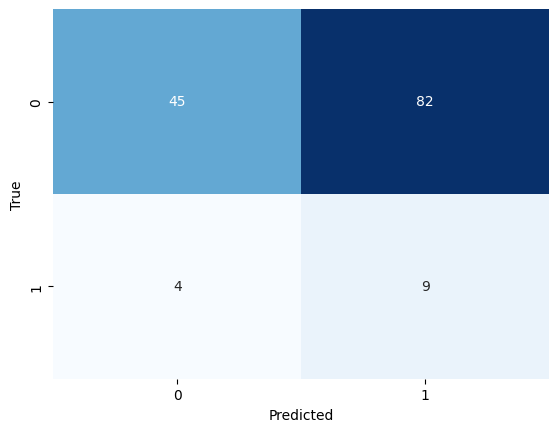

28/28 [==============================] - 0s 7ms/step
              precision    recall  f1-score     support
0              0.918367  0.354331  0.511364  127.000000
1              0.098901  0.692308  0.173077   13.000000
accuracy       0.385714  0.385714  0.385714    0.385714
macro avg      0.508634  0.523319  0.342220  140.000000
weighted avg   0.842274  0.385714  0.479951  140.000000
28/28 [==============================] - 0s 7ms/step


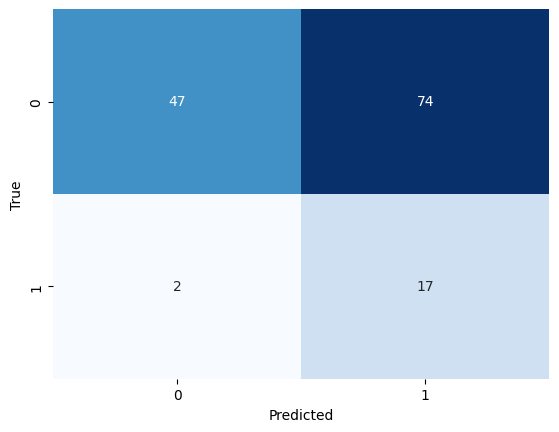

28/28 [==============================] - 0s 8ms/step
              precision    recall  f1-score     support
0              0.959184  0.388430  0.552941  121.000000
1              0.186813  0.894737  0.309091   19.000000
accuracy       0.457143  0.457143  0.457143    0.457143
macro avg      0.572998  0.641583  0.431016  140.000000
weighted avg   0.854362  0.457143  0.519847  140.000000


In [253]:
confusion_matrix_plot(model_3, train_gen, save_file='models/evaluate/model_3_train_confusion_matrix.pdf')
classification_report_output(model_3, train_gen, save_file=None)
confusion_matrix_plot(model_3, val_gen, save_file='models/evaluate/model_3_val_confusion_matrix.pdf')
classification_report_output(model_3, val_gen, save_file=None)
confusion_matrix_plot(model_3, test_gen, save_file='models/evaluate/model_3_test_confusion_matrix.pdf')
classification_report_output(model_3, test_gen, save_file=None)

In [254]:
# Model 4
def build_lstm_conv_lstm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
  from tensorflow.keras.optimizers import Adam

  # Define the input shape
  inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

  # Add a 1D convolutional layer to extract features
  x = Conv1D(filters=9, kernel_size=9, activation='relu', padding='same')(inputs)
  x = MaxPooling1D(pool_size=2)(x)
  x = Conv1D(filters=9, kernel_size=3, activation='relu', padding='same')(x)
  x = MaxPooling1D(pool_size=2)(x)

  # LSTM layer
  x = LSTM(27, activation='tanh', return_sequences=True)(x)

  # Flatten the output
  x = Flatten()(x)

  # Dense layer
  x = Dense(lstm_units//2, activation='relu')(x)

  # Dropout layer
  x = Dropout(0.5)(x)

  # Add the output layer
  outputs = Dense(1, activation='sigmoid')(x)

  # Create the model
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model


In [255]:
# Parameters for fitting and saving model training data
epochs = 200
model_4_filepath = 'models/model_4_conv_lstm.keras'
history_4_filepath = 'models/trainHistoryDict/model_4_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.01]

In [256]:
# Fit the model and tune hyperparameters
history_4, model_4, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_conv_lstm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_4_filepath)
# Pickle the Training Fit History
with open(history_4_filepath, 'wb') as file_pi:
    pickle.dump(history_4, file_pi)

lstm_units: 32, learning_rate: 0.001, weight_penalty: 1
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 300, 20)]         0         
                                                                 
 conv1d_12 (Conv1D)          (None, 300, 9)            1629      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 150, 9)           0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 150, 9)            252       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 75, 9)            0         
 1D)                                                             
                                                                 
 l

28/28 [==============================] - 1s 9ms/step - loss: 0.5632 - binary_accuracy: 0.6000


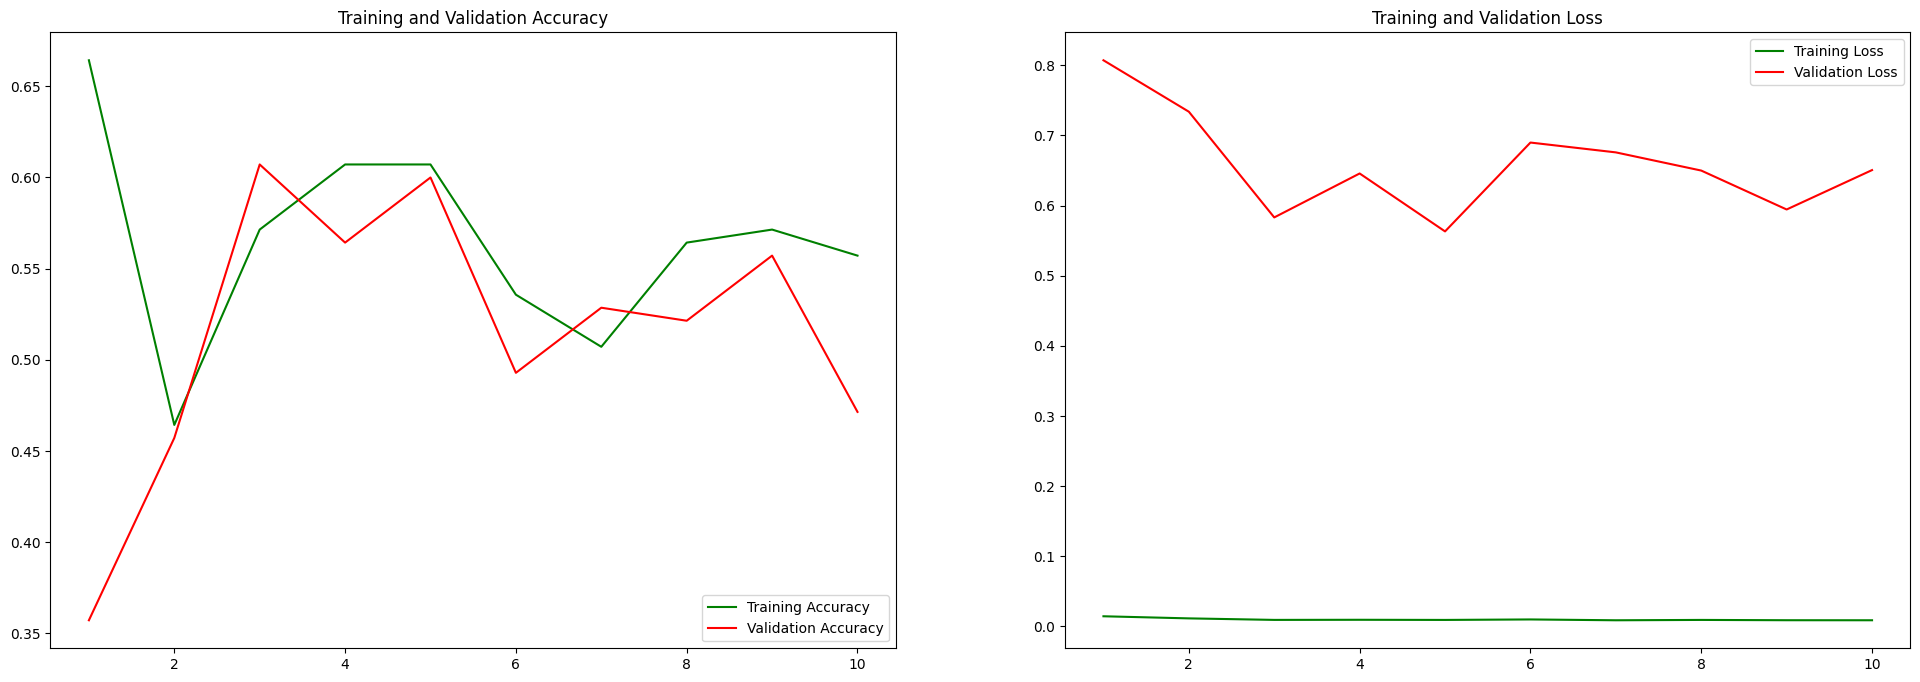

Validation Binary Accuracy is: 0.60
28/28 [==============================] - 0s 9ms/step - loss: 0.6227 - binary_accuracy: 0.5286
Testing Binary Accuracy is: 0.53


In [257]:
# Load and Evaluate Model
model_4, history_4 = evaluate_model(model_4_filepath, 
                         history_4_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_4_evaluation.pdf')

28/28 [==============================] - 0s 3ms/step


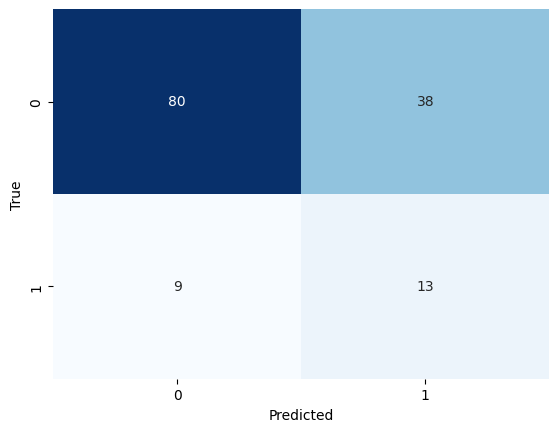

28/28 [==============================] - 0s 3ms/step
              precision    recall  f1-score     support
0              0.898876  0.677966  0.772947  118.000000
1              0.254902  0.590909  0.356164   22.000000
accuracy       0.664286  0.664286  0.664286    0.664286
macro avg      0.576889  0.634438  0.564556  140.000000
weighted avg   0.797680  0.664286  0.707452  140.000000
28/28 [==============================] - 0s 3ms/step


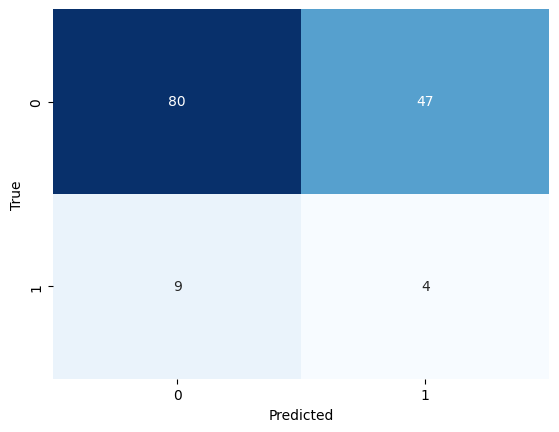

28/28 [==============================] - 0s 3ms/step
              precision    recall  f1-score  support
0              0.898876  0.629921  0.740741    127.0
1              0.078431  0.307692  0.125000     13.0
accuracy       0.600000  0.600000  0.600000      0.6
macro avg      0.488654  0.468807  0.432870    140.0
weighted avg   0.822692  0.600000  0.683565    140.0
28/28 [==============================] - 0s 3ms/step


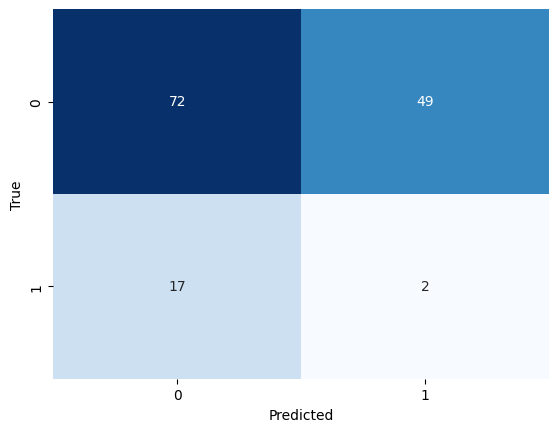

28/28 [==============================] - 0s 3ms/step
              precision    recall  f1-score     support
0              0.808989  0.595041  0.685714  121.000000
1              0.039216  0.105263  0.057143   19.000000
accuracy       0.528571  0.528571  0.528571    0.528571
macro avg      0.424102  0.350152  0.371429  140.000000
weighted avg   0.704520  0.528571  0.600408  140.000000


In [258]:
confusion_matrix_plot(model_4, train_gen, save_file='models/evaluate/model_4_train_confusion_matrix.pdf')
classification_report_output(model_4, train_gen, save_file=None)
confusion_matrix_plot(model_4, val_gen, save_file='models/evaluate/model_4_val_confusion_matrix.pdf')
classification_report_output(model_4, val_gen, save_file=None)
confusion_matrix_plot(model_4, test_gen, save_file='models/evaluate/model_4_test_confusion_matrix.pdf')
classification_report_output(model_4, test_gen, save_file=None)

In [259]:
# Model 5: Bidirectional LSTM
def build_bidirection_lstm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Bidirectional
  from tensorflow.keras.optimizers import Adam

  # Define the input shape
  inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

  # Next model add a Dense layer here
  x = Bidirectional(LSTM(lstm_units, 
                         activation='tanh', 
                         return_sequences=True,
                         dropout=0.5))(inputs)
  x = Bidirectional(LSTM(lstm_units, 
                         activation='tanh', 
                         #return_sequences=True,
                         dropout=0.5))(x)
  x = Dense(units=batch_size//2, 
            activation='relu')(x)

  outputs = Dense(units=1, activation='sigmoid')(x)

  # Build the model
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model

In [260]:
# Parameters for fitting and saving model training data
epochs = 200
model_6_filepath = 'models/model_6_bidirectional.keras'
history_6_filepath = 'models/trainHistoryDict/model_6_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.0001, 0.001, 0.01, 0.1]
class_weight_penalty= [1] #[1, 2, 10, 100, 1000]

In [261]:
# Fit the model and tune hyperparameters
history_6, model_6, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_bidirection_lstm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_6_filepath)
# Pickle the Training Fit History
with open(history_6_filepath, 'wb') as file_pi:
    pickle.dump(history_6, file_pi)

lstm_units: 32, learning_rate: 0.001, weight_penalty: 1
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 300, 20)]         0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 300, 64)          13568     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_25 (Dense)            (None, 71)                4615      
                                                                 
 dense_26 (Dense)            (None, 1)                 72        
                                                                 
To

28/28 [==============================] - 2s 21ms/step - loss: 0.6177 - binary_accuracy: 0.5857


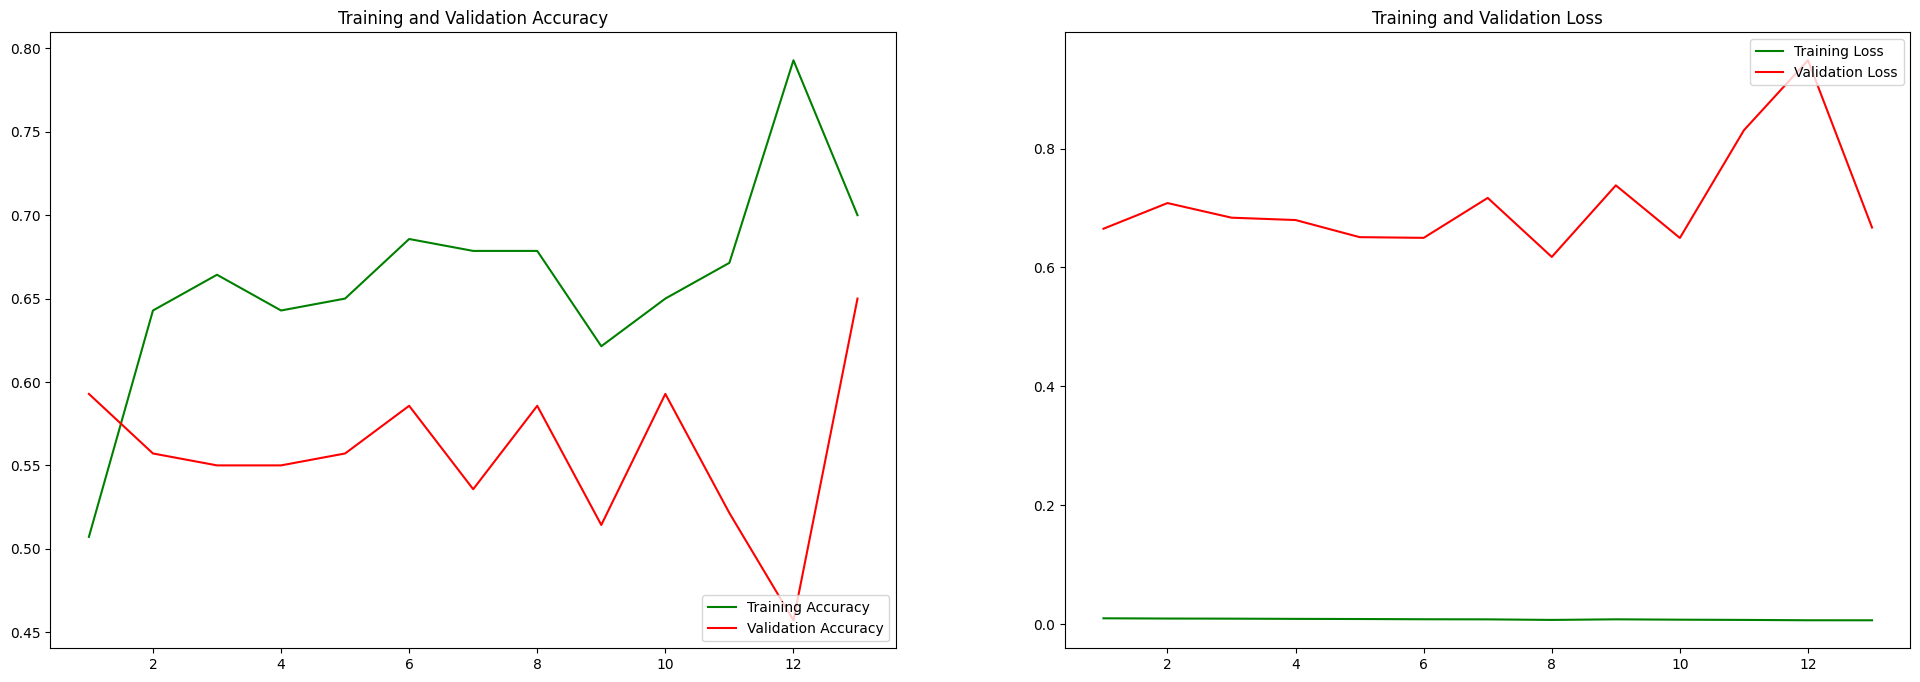

Validation Binary Accuracy is: 0.59
28/28 [==============================] - 1s 20ms/step - loss: 0.7414 - binary_accuracy: 0.5143
Testing Binary Accuracy is: 0.51


In [262]:
# Fit the model to the training data
# Load and Evaluate Model
model_6, history_6 = evaluate_model(model_6_filepath, 
                         history_6_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_6_evaluation.pdf')

28/28 [==============================] - 2s 15ms/step


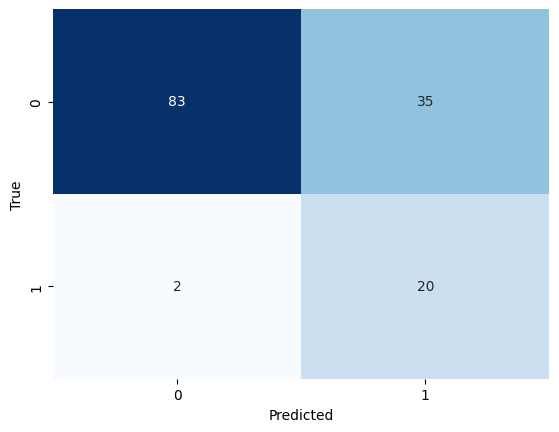

28/28 [==============================] - 0s 13ms/step
              precision    recall  f1-score     support
0              0.976471  0.703390  0.817734  118.000000
1              0.363636  0.909091  0.519481   22.000000
accuracy       0.735714  0.735714  0.735714    0.735714
macro avg      0.670053  0.806240  0.668607  140.000000
weighted avg   0.880168  0.735714  0.770866  140.000000
28/28 [==============================] - 0s 13ms/step


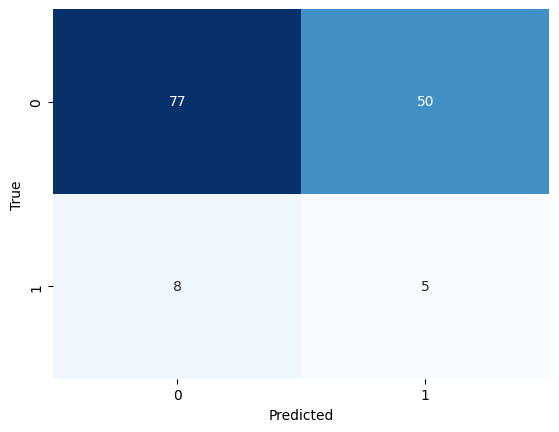

28/28 [==============================] - 0s 13ms/step
              precision    recall  f1-score     support
0              0.905882  0.606299  0.726415  127.000000
1              0.090909  0.384615  0.147059   13.000000
accuracy       0.585714  0.585714  0.585714    0.585714
macro avg      0.498396  0.495457  0.436737  140.000000
weighted avg   0.830206  0.585714  0.672618  140.000000
28/28 [==============================] - 0s 13ms/step


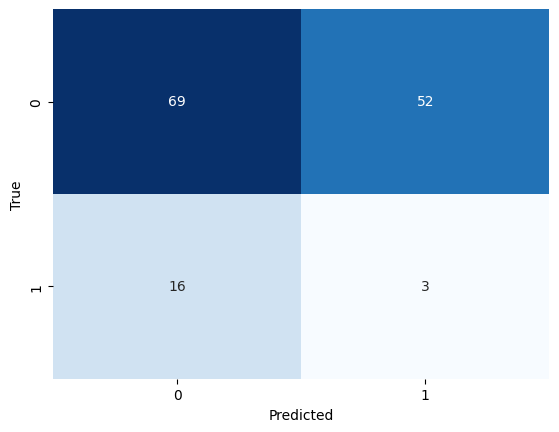

28/28 [==============================] - 0s 13ms/step
              precision    recall  f1-score     support
0              0.811765  0.570248  0.669903  121.000000
1              0.054545  0.157895  0.081081   19.000000
accuracy       0.514286  0.514286  0.514286    0.514286
macro avg      0.433155  0.364071  0.375492  140.000000
weighted avg   0.708999  0.514286  0.589991  140.000000


In [263]:
confusion_matrix_plot(model_6, train_gen, save_file='models/evaluate/model_6_train_confusion_matrix.pdf')
classification_report_output(model_6, train_gen, save_file=None)
confusion_matrix_plot(model_6, val_gen, save_file='models/evaluate/model_6_val_confusion_matrix.pdf')
classification_report_output(model_6, val_gen, save_file=None)
confusion_matrix_plot(model_6, test_gen, save_file='models/evaluate/model_6_test_confusion_matrix.pdf')
classification_report_output(model_6, test_gen, save_file=None)

In [264]:
'''
Model_7: Timeseries classification with a transformer model
Attention is all you need.
'''
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, 
                                  num_heads=num_heads, 
                                  dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_model(
    input_shape,
    n_classes,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

# Build model
model_7 = build_transformer_model(
                seq_length,
                n_classes=1,
                head_size=256,
                num_heads=4, # Number of Transformer repeats
                ff_dim=4,
                num_transformer_blocks=4,
                mlp_units=[128],
                mlp_dropout=0.4,
                dropout=0.5,
)

# Compile Model
model_7.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=best_learning_rate),
    metrics=["binary_accuracy"],
)
model_7.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 300, 20)]    0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 300, 20)     40          ['input_20[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 300, 20)     85012       ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                                           

In [265]:
# Parameters for fitting and saving model training data
epochs = 200
model_7_filepath = 'models/model_7_transformer.keras'
history_7_filepath = 'models/trainHistoryDict/model_7_history.pkl'

In [266]:
# Fit the model to the training data
history_7 = model_7.fit(train_gen, 
                        validation_data=val_gen,
                        shuffle=False, 
                        epochs=epochs, 
                        callbacks=callbacks(model_7_filepath,
                                            patience=5))

# Pickle the Traning Fit History
with open(history_7_filepath, 'wb') as file_pi:
    pickle.dump(history_7, file_pi)

Epoch 1/200
28/28 [==============================] - 15s 84ms/step - loss: 0.4314 - binary_accuracy: 0.1571 - val_loss: 0.4148 - val_binary_accuracy: 0.0929
Epoch 2/200
28/28 [==============================] - 2s 57ms/step - loss: 0.5242 - binary_accuracy: 0.1571 - val_loss: 0.5319 - val_binary_accuracy: 0.0929
Epoch 3/200
28/28 [==============================] - 2s 66ms/step - loss: 0.5470 - binary_accuracy: 0.1571 - val_loss: 0.3549 - val_binary_accuracy: 0.0929
Epoch 4/200
28/28 [==============================] - 2s 56ms/step - loss: 0.4474 - binary_accuracy: 0.1571 - val_loss: 0.5079 - val_binary_accuracy: 0.0929
Epoch 5/200
28/28 [==============================] - 2s 65ms/step - loss: 0.4577 - binary_accuracy: 0.1571 - val_loss: 0.3525 - val_binary_accuracy: 0.0929
Epoch 6/200
28/28 [==============================] - 2s 56ms/step - loss: 0.4211 - binary_accuracy: 0.1571 - val_loss: 0.4607 - val_binary_accuracy: 0.0929
Epoch 7/200
28/28 [==============================] - 2s 55ms/st

28/28 [==============================] - 1s 15ms/step - loss: 0.3525 - binary_accuracy: 0.0929


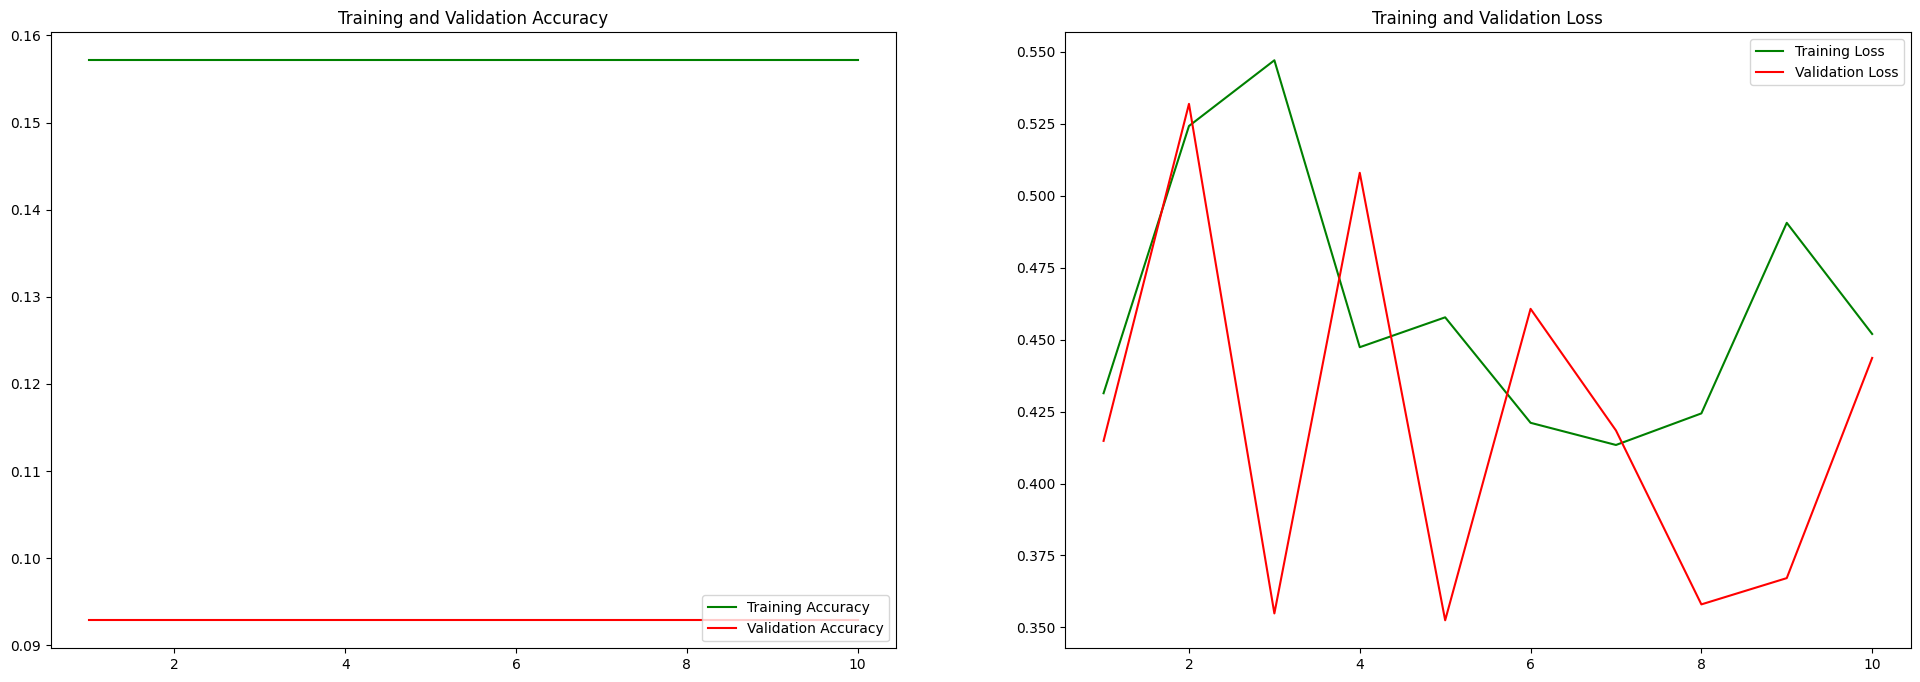

Validation Binary Accuracy is: 0.09
28/28 [==============================] - 1s 18ms/step - loss: 0.4344 - binary_accuracy: 0.1357
Testing Binary Accuracy is: 0.14


In [267]:
# Load and Evaluate Model
model_7, history_7 = evaluate_model(model_7_filepath, 
                         history_7_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_7_evaluation.pdf')

28/28 [==============================] - 1s 9ms/step


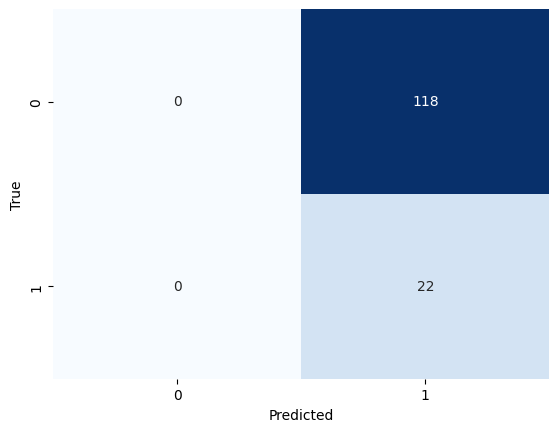

28/28 [==============================] - 0s 7ms/step
              precision    recall  f1-score     support
0              0.000000  0.000000  0.000000  118.000000
1              0.157143  1.000000  0.271605   22.000000
accuracy       0.157143  0.157143  0.157143    0.157143
macro avg      0.078571  0.500000  0.135802  140.000000
weighted avg   0.024694  0.157143  0.042681  140.000000
16/28 [================>.............] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 0s 7ms/step


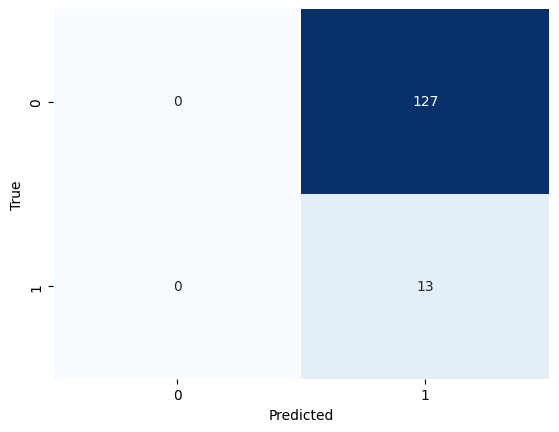

28/28 [==============================] - 0s 7ms/step
              precision    recall  f1-score     support
0              0.000000  0.000000  0.000000  127.000000
1              0.092857  1.000000  0.169935   13.000000
accuracy       0.092857  0.092857  0.092857    0.092857
macro avg      0.046429  0.500000  0.084967  140.000000
weighted avg   0.008622  0.092857  0.015780  140.000000
16/28 [================>.............] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28/28 [==============================] - 0s 7ms/step


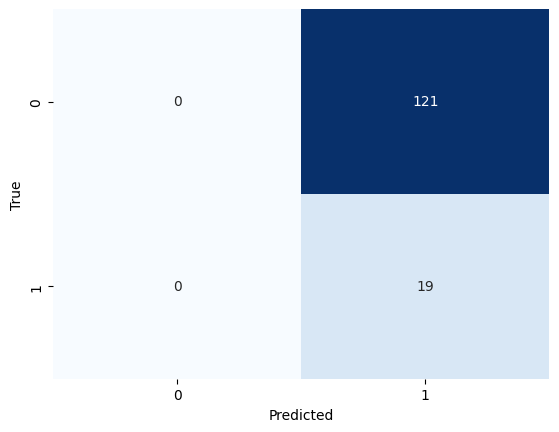

28/28 [==============================] - 0s 7ms/step
              precision    recall  f1-score     support
0              0.000000  0.000000  0.000000  121.000000
1              0.135714  1.000000  0.238994   19.000000
accuracy       0.135714  0.135714  0.135714    0.135714
macro avg      0.067857  0.500000  0.119497  140.000000
weighted avg   0.018418  0.135714  0.032435  140.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [268]:
confusion_matrix_plot(model_7, train_gen, save_file='models/evaluate/model_7_train_confusion_matrix.pdf')
classification_report_output(model_7, train_gen, save_file=None)
confusion_matrix_plot(model_7, val_gen, save_file='models/evaluate/model_7_val_confusion_matrix.pdf')
classification_report_output(model_7, val_gen, save_file=None)
confusion_matrix_plot(model_7, test_gen, save_file='models/evaluate/model_7_test_confusion_matrix.pdf')
classification_report_output(model_7, test_gen, save_file=None)

In [310]:
# XGBoost and Random Forests
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Extract features and labels from the TimeseriesGenerator
X_train = np.concatenate([batch[0] for batch in train_gen])
y_train = np.concatenate([batch[1] for batch in train_gen])

X_val = np.concatenate([batch[0] for batch in val_gen])
y_val = np.concatenate([batch[1] for batch in val_gen])

X_test = np.concatenate([batch[0] for batch in test_gen])
y_test = np.concatenate([batch[1] for batch in test_gen])

# Reshape the data into a 2D format
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_val_2d = X_val.reshape(X_val.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

In [311]:
X_train_2d.shape

(140, 6000)

In [309]:
len(X_train)

140

In [330]:
X_train = train_df.drop(['label', 'subject'], axis=1)
y_train = train_df['label']

X_val = val_df.drop(['label', 'subject'], axis=1)
y_val = val_df['label']

X_test = test_df.drop(['label', 'subject'], axis=1)
y_test = test_df['label']

In [328]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search over
param_grid = {
    'tree_method': ['gpu_hist'],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5]
}

#Train an XGBoost model:
xgb_model = XGBClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=5, 
    error_score='raise',
    scoring='accuracy',
    verbose=3,
    n_jobs=-1 #all available GPU cores
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)




Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 6, 9], 'n_estimators': [50, 100, 150],
                         'tree_method': ['gpu_hist']},
             scoring='accuracy', verbose=3)

In [333]:
# Print the best hyperparameters and the corresponding validation accuracy
y_train_pred = grid_search.predict(X_train)
y_val_pred = grid_search.predict(X_val)
y_test_pred = grid_search.predict(X_test)
print("Best hyperparameters:", grid_search.best_params_)
print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))

# Print confusion matrix for training set
print("Confusion matrix (training set):\n", confusion_matrix(y_train, y_train_pred))

# Print classification report for training set
print("Classification report (training set):\n", classification_report(y_train, y_train_pred))

# Print confusion matrix for validation set
print("Confusion matrix (validation set):\n", confusion_matrix(y_val, y_val_pred))

# Print classification report for validation set
print("Classification report (validation set):\n", classification_report(y_val, y_val_pred))

# Print confusion matrix for testing set
print("Confusion matrix (testing set):\n", confusion_matrix(y_test, y_test_pred))

# Print classification report for testing set
print("Classification report (testing set):\n", classification_report(y_test, y_test_pred))

Best hyperparameters: {'learning_rate': 0.5, 'max_depth': 6, 'n_estimators': 50, 'tree_method': 'gpu_hist'}
Train accuracy: 1.0
Validation accuracy: 0.9992578849721707
Confusion matrix (training set):
 [[37841     0]
 [    0  5247]]
Classification report (training set):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     37841
           1       1.00      1.00      1.00      5247

    accuracy                           1.00     43088
   macro avg       1.00      1.00      1.00     43088
weighted avg       1.00      1.00      1.00     43088

Confusion matrix (validation set):
 [[9522    4]
 [   4 1250]]
Classification report (validation set):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9526
           1       1.00      1.00      1.00      1254

    accuracy                           1.00     10780
   macro avg       1.00      1.00      1.00     10780
weighted avg       1.00  

In [334]:
import pandas as pd
import numpy as np

# Get the booster object
booster = grid_search.best_estimator_.get_booster()

# Get the feature importance scores
feature_importances = booster.get_score(importance_type="weight")

# Create a dataframe to store the feature importance scores
fi_df = pd.DataFrame({'feature': list(feature_importances.keys()), 'importance': list(feature_importances.values())})

# Sort the dataframe by feature importance scores in descending order
fi_df = fi_df.sort_values(by='importance', ascending=False)

# Print the top ten most important features
print(fi_df.head(10))

{'f21': 1.0, 'f108': 1.0, 'f146': 1.0, 'f168': 1.0, 'f189': 1.0, 'f193': 1.0, 'f211': 1.0, 'f256': 2.0, 'f273': 5.0, 'f481': 1.0, 'f527': 3.0, 'f625': 2.0, 'f628': 1.0, 'f662': 2.0, 'f715': 1.0, 'f734': 1.0, 'f752': 1.0, 'f804': 1.0, 'f814': 1.0, 'f826': 3.0, 'f865': 2.0, 'f1009': 1.0, 'f1044': 1.0, 'f1065': 1.0, 'f1180': 1.0, 'f1181': 2.0, 'f1282': 1.0, 'f1330': 1.0, 'f1340': 3.0, 'f1348': 1.0, 'f1405': 1.0, 'f1408': 1.0, 'f1487': 2.0, 'f1499': 1.0, 'f1536': 1.0, 'f1587': 1.0, 'f1645': 2.0, 'f1665': 1.0, 'f1675': 2.0, 'f1693': 3.0, 'f1705': 1.0, 'f1860': 1.0, 'f1861': 1.0, 'f1868': 1.0, 'f1873': 1.0, 'f1930': 1.0, 'f1942': 1.0, 'f1975': 1.0, 'f2042': 2.0, 'f2073': 1.0, 'f2081': 1.0, 'f2095': 1.0, 'f2099': 4.0, 'f2101': 1.0, 'f2197': 1.0, 'f2219': 10.0, 'f2282': 1.0, 'f2306': 1.0, 'f2425': 4.0, 'f2429': 1.0, 'f2525': 1.0, 'f2545': 5.0, 'f2609': 1.0, 'f2610': 1.0, 'f2617': 2.0, 'f2633': 1.0, 'f2635': 3.0, 'f2722': 3.0, 'f2745': 1.0, 'f2759': 1.0, 'f2801': 1.0, 'f2861': 1.0, 'f2870': 9.0

In [274]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search over
param_grid = {
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
}

# Create a RandomForestClassifier object
rf_model = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    verbose=3,
    n_jobs=-1 #all available cores
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_2d, y_train)

# Print the best hyperparameters and the corresponding validation accuracy
print("Best hyperparameters:", grid_search.best_params_)
print("Validation accuracy:", grid_search.best_score_)

# Get the predicted labels on the training and validation sets
y_train_pred = grid_search.predict(X_train)
y_val_pred = grid_search.predict(X_val)

# Print the accuracy scores on the training and validation sets
print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best hyperparameters: {'max_depth': 3, 'n_estimators': 150}
Validation accuracy: 0.7214285714285714


ValueError: ignored

In [ ]:
# Feature importance
# Get feature importances
feature_importances = pd.DataFrame(
    rf_model.feature_importances_, index=X_train.columns, columns=['importance']
).sort_values('importance', ascending=False)

# Print feature importances
print('Feature importances:')
print(feature_importances)

In [ ]:
# Print confusion matrix for training set
print("Confusion matrix (training set):\n", confusion_matrix(y_train, y_train_pred))

# Print classification report for training set
print("Classification report (training set):\n", classification_report(y_train, y_train_pred))

# Print confusion matrix for validation set
print("Confusion matrix (validation set):\n", confusion_matrix(y_val, y_val_pred))

# Print classification report for validation set
print("Classification report (validation set):\n", classification_report(y_val, y_val_pred))